#### Importing Functions

In [2]:
from utils import *

#### Importing the libraries

In [3]:
import cv2
import os
import tifffile # for reading tiff files. There are other modules that can do this, but tifffile is most stable on Windows
import numpy as np # for array handling
import matplotlib.pyplot as plt # for QC
import glob # to gather up image filepath lists
import rasterio
from rasterio.plot import show
import scipy # same
import imagecodecs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from skimage.transform import resize
from skimage.util import random_noise
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K

#### Load and  Display the data 

In [4]:
training_file_path = 'D:\EAGLE_Deep_Learning\Glacier-Regression-Detection-Deep-Learning\Data\scenes\*.tif'
testing_file_path = "D:\EAGLE_Deep_Learning\Glacier-Regression-Detection-Deep-Learning\masks\*.tif"

In [6]:
top_train_list = read_data(training_file_path)
print(top_train_list)

['D:\\EAGLE_Deep_Learning\\Glacier-Regression-Detection-Deep-Learning\\Data\\scenes\\L1C_T21DVJ_A026576_20220408T131906.tif'
 'D:\\EAGLE_Deep_Learning\\Glacier-Regression-Detection-Deep-Learning\\Data\\scenes\\L1C_T21EWK_A026776_20220422T125859.tif'
 'D:\\EAGLE_Deep_Learning\\Glacier-Regression-Detection-Deep-Learning\\Data\\scenes\\L1C_T21EXK_A026776_20220422T125859.tif'
 'D:\\EAGLE_Deep_Learning\\Glacier-Regression-Detection-Deep-Learning\\Data\\scenes\\L1C_T23VMH_A024904_20211212T143513.tif'
 'D:\\EAGLE_Deep_Learning\\Glacier-Regression-Detection-Deep-Learning\\Data\\scenes\\L1C_T23VMH_A025147_20211229T142513.tif'
 'D:\\EAGLE_Deep_Learning\\Glacier-Regression-Detection-Deep-Learning\\Data\\scenes\\L1C_T23VNG_A025147_20211229T142513.tif'
 'D:\\EAGLE_Deep_Learning\\Glacier-Regression-Detection-Deep-Learning\\Data\\scenes\\L1C_T23VNH_A025147_20211229T142513.tif'
 'D:\\EAGLE_Deep_Learning\\Glacier-Regression-Detection-Deep-Learning\\Data\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T2

In [7]:
#Available validation scenes
top_test_list = read_data(testing_file_path)
print(top_test_list)

['D:\\EAGLE_Deep_Learning\\Glacier-Regression-Detection-Deep-Learning\\masks\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-11.tif'
 'D:\\EAGLE_Deep_Learning\\Glacier-Regression-Detection-Deep-Learning\\masks\\S2B_MSIL1C_20220302T132919_N0400_R138_T20DMN_20220302T163212-11.tif'
 'D:\\EAGLE_Deep_Learning\\Glacier-Regression-Detection-Deep-Learning\\masks\\S2B_MSIL2A_20211129T131909_N0301_R095_T19DEE_20211129T151203-2.tif'
 'D:\\EAGLE_Deep_Learning\\Glacier-Regression-Detection-Deep-Learning\\masks\\S2B_MSIL2A_20211129T131909_N0301_R095_T19DEE_20211129T151203-3.tif'
 'D:\\EAGLE_Deep_Learning\\Glacier-Regression-Detection-Deep-Learning\\masks\\S2B_MSIL2A_20211129T131909_N0301_R095_T19DEE_20211129T151203-4.tif'
 'D:\\EAGLE_Deep_Learning\\Glacier-Regression-Detection-Deep-Learning\\masks\\S2B_MSIL2A_20211129T131909_N0301_R095_T19DEE_20211129T151203-5.tif']


#### Visualize a Training Image for Testing

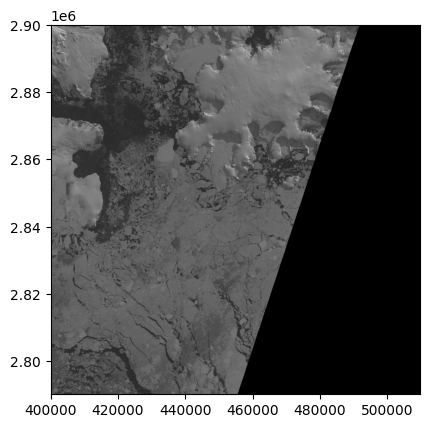

In [8]:
src = rasterio.open("D:\EAGLE_Deep_Learning\Glacier-Regression-Detection-Deep-Learning\Data\scenes\L1C_T21DVJ_A026576_20220408T131906.tif")
img0 = show(src.read(1),transform=src.transform, cmap='gray')

#### Resize the Data

In [9]:
#creating empty arrays to store our data
imgResize = 512
channels = 3
train_dir, test_dir = create_arrays(512, 3)

In [10]:
resized_training_images = resize_images(imgResize, channels, top_train_list, train_dir)
resized_testing_images = resize_images(imgResize, channels, top_test_list, test_dir)

#### Let's process our Labels

##### Load our mask data

In [11]:
train_mask_path = 'D:\EAGLE_Deep_Learning\Glacier-Regression-Detection-Deep-Learning\Data\masks\*.tif'

label_train_list = read_data(train_mask_path)
# print(label_train_list)

In [12]:
# BUG FIX
testing_mask_path = 'D:\EAGLE_Deep_Learning\Glacier-Regression-Detection-Deep-Learning\masks\*.tif'

label_test_list = read_data(testing_mask_path)
# print(label_test_list)

#### Visualize one of the training labels

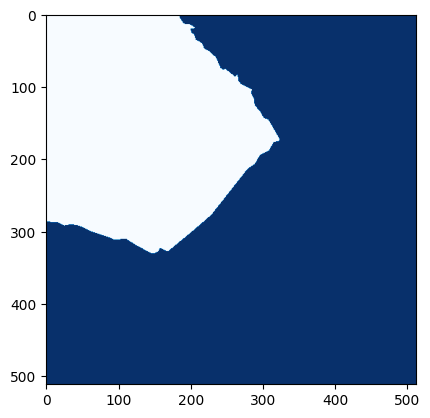

In [13]:
#Lets have a look at our labels
plot_label(label_train_list, 7)



#### Let's start reshaping our labels.

In [14]:
# Define the directory where you want to save the individual label images
label_save_dir_train = './train_label_images/'
label_save_dir_test = './test_label_images/'

# Using the function create_dir to create file directories for saving labelled images for training and testing
create_dir(label_save_dir_train)
create_dir(label_save_dir_test)

In [15]:
label_train_total = label_list_to_array(label_train_list, imgResize, 3)

In [16]:
label_test_total = label_list_to_array(label_test_list, imgResize, 3)

In [17]:
onehot_label_train_total = onehot_label(label_train_total, label_train_list, imgResize, 2)

In [18]:
onehot_label_test_total = onehot_label(label_test_total, label_test_list, imgResize, 2)

#### Checking how one-hot-encoded labels look like

[0. 1.]


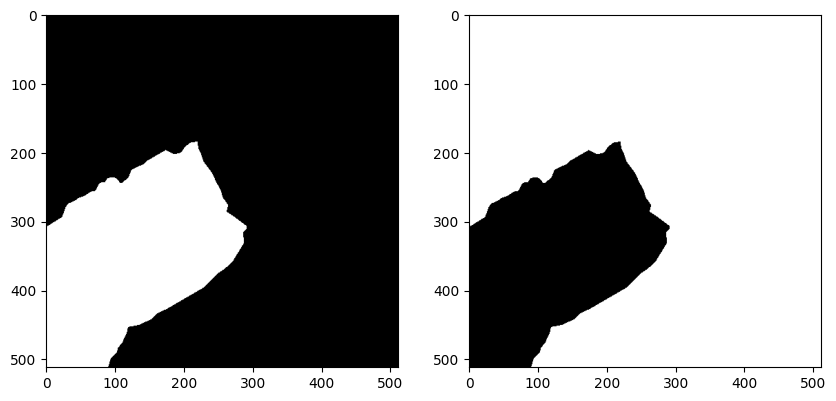

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(onehot_label_test_total[2,:,:,0], cmap='gray')
axes[1].imshow(onehot_label_test_total[2,:,:,1], cmap='gray')
print(np.unique(onehot_label_train_total))

#### Save our Labels

In [20]:
np.save('D:/EAGLE_Deep_Learning/Glacier-Regression-Detection-Deep-Learning/Scripts/train_label_images/label_train.npy', onehot_label_train_total)
np.save('D:/EAGLE_Deep_Learning/Glacier-Regression-Detection-Deep-Learning/Scripts/test_label_images/label_test.npy', onehot_label_test_total)

## Training the Neural Network

This Tutorial was created by C. Baumhoer and is based on work from https://github.com/mmorphew/unet_remote_sensing & https://github.com/karolzak/keras-unet


#### Load our Data

In [21]:
# Load and convert train and testing data into arrays
data_files_train = np.sort(label_train_total)
data_files_test = np.sort(label_test_total)

We need to tell Tensorflow the size of our input image. We select 512 by 512 since that was how we resized our image collection

In [22]:
nx = 512
ny = 512

To improve learning, let's standardize globally by subtracting the mean and dividing by the standard deviation.

In [23]:
data_scaled = standardize_data(data_files_train)
data_test_scaled = standardize_data(data_files_test)

We assign our Data to Variables

In [24]:
x = data_scaled
y = onehot_label_train_total[:,:,:] # exclude clutter
x_test = data_test_scaled
y_test = onehot_label_test_total[:,:,:]

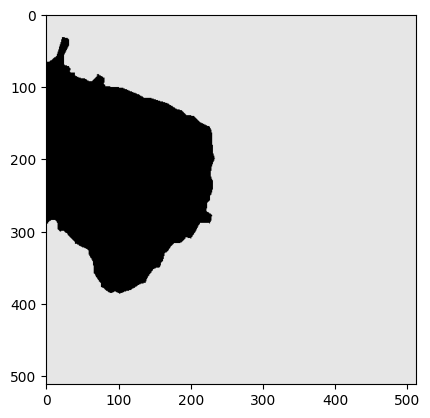

In [25]:
# Plot a random image to see if everything looks alright
plt.imshow(x[15])

We split our dataset into a portion for training and a portion for validation.

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=1234)

Let's augment our training data, we flip the images in various ways, add noise, etc.

In [27]:
# Data augmentation on just the training data
## Image Augmentation
# Vertical Image
Vx = [np.flip(x, axis=1) for x in x_train]
Vy = [np.flip(x, axis=1) for x in y_train]

# Horizontal Image
Hx = [np.flip(x, axis=2) for x in x_train]
Hy = [np.flip(x, axis=2) for x in y_train]

# Horizontal Vertical Image
HVx = [np.flip(x, axis=2) for x in Vx]
HVy = [np.flip(x, axis=2) for x in Vy]

# Appending the augmented image and mask to the main dataset.
x_train = np.append(x_train, Vx, axis=0)
y_train = np.append(y_train, Vy, axis=0)

x_train = np.append(x_train, Hx, axis=0)
y_train = np.append(y_train, Hy, axis=0)

x_train = np.append(x_train, HVx, axis=0)
y_train = np.append(y_train, HVy, axis=0)


#### Define the Neural Network

Let's create a model object, compile it, and summarize it so we can make sure the layers were built the way we wanted them to be built by Keras. We'll also define our optimizer, Adam, and pick a loss function and tracking metrics.

In [28]:
model = satellite_unet(input_shape=(512, 512, 3), num_classes=2, output_activation='sigmoid', num_layers=3 )
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=["categorical_accuracy", f1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 64)         36928     ['batch_normalization[0][0

----- 

Callbacks for instructing Tensorflow on how to behave during training. 

In [29]:
#Let's save our model checkpoints relative to epoch and loss
checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'

In [30]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=30, min_lr=0.00001, verbose=1),
    ModelCheckpoint(checkpoint_filepath, monitor='val_categorical_accuracy',
    mode='max',verbose=1, save_best_only=True, save_weights_only=True)
]

#### Now let's train our model!

In [31]:
results = model.fit(x_train, y_train, batch_size= 4, epochs=2, callbacks=callbacks,
                   validation_data=(x_val, y_val))

Epoch 1/2
26/26 [==============================] - ETA: 0s - loss: 1.0371 - categorical_accuracy: 0.5205 - f1: 0.3555 
Epoch 1: val_categorical_accuracy improved from -inf to 0.32227, saving model to weights.01-0.85.h5
26/26 [==============================] - 560s 21s/step - loss: 1.0371 - categorical_accuracy: 0.5205 - f1: 0.3555 - val_loss: 0.8463 - val_categorical_accuracy: 0.3223 - val_f1: 0.2541 - lr: 0.0010
Epoch 2/2
26/26 [==============================] - ETA: 0s - loss: 0.7207 - categorical_accuracy: 0.5783 - f1: 0.3243 
Epoch 2: val_categorical_accuracy improved from 0.32227 to 0.52865, saving model to weights.02-0.76.h5
26/26 [==============================] - 546s 21s/step - loss: 0.7207 - categorical_accuracy: 0.5783 - f1: 0.3243 - val_loss: 0.7558 - val_categorical_accuracy: 0.5286 - val_f1: 0.3467 - lr: 0.0010


#### Accuracy Check

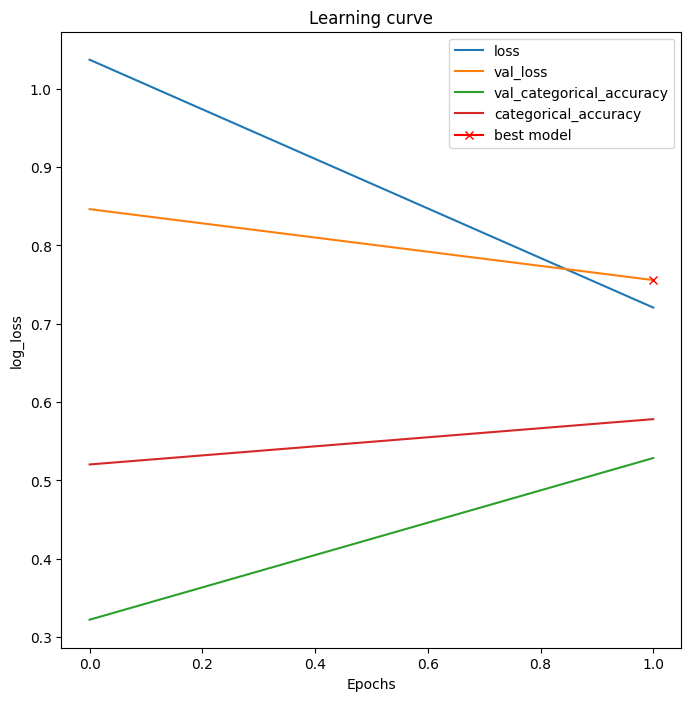

In [32]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(results.history["val_categorical_accuracy"], label="val_categorical_accuracy")
plt.plot(results.history["categorical_accuracy"], label="categorical_accuracy")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

#### Evaluate the trained weights and predict

In [34]:
# Load best model
# Have a look at all saved models and take the one with the highest epoch value
model.load_weights('D:\EAGLE_Deep_Learning\Glacier-Regression-Detection-Deep-Learning\Scripts\weights.02-0.76.h5')

In [35]:
# Evaluate on test set
eval = model.evaluate(x_test, y_test)
print('Test loss:', eval[0])
print('Test accuracy:', eval[1])

1/1 [==============================] - 4s 4s/step - loss: 0.7053 - categorical_accuracy: 0.6271 - f1: 0.3854
Test loss: 0.7052933573722839
Test accuracy: 0.6271393895149231


In [36]:
# Predict on train, val and test
preds_train = model.predict(x_train[0:10], verbose=1)
preds_val = model.predict(x_val, verbose=1)
preds_test = model.predict(x_test, verbose=1)

1/1 [==============================] - 7s 7s/step


In [37]:
# Threshold prediction probabilities
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

#### Plot Results

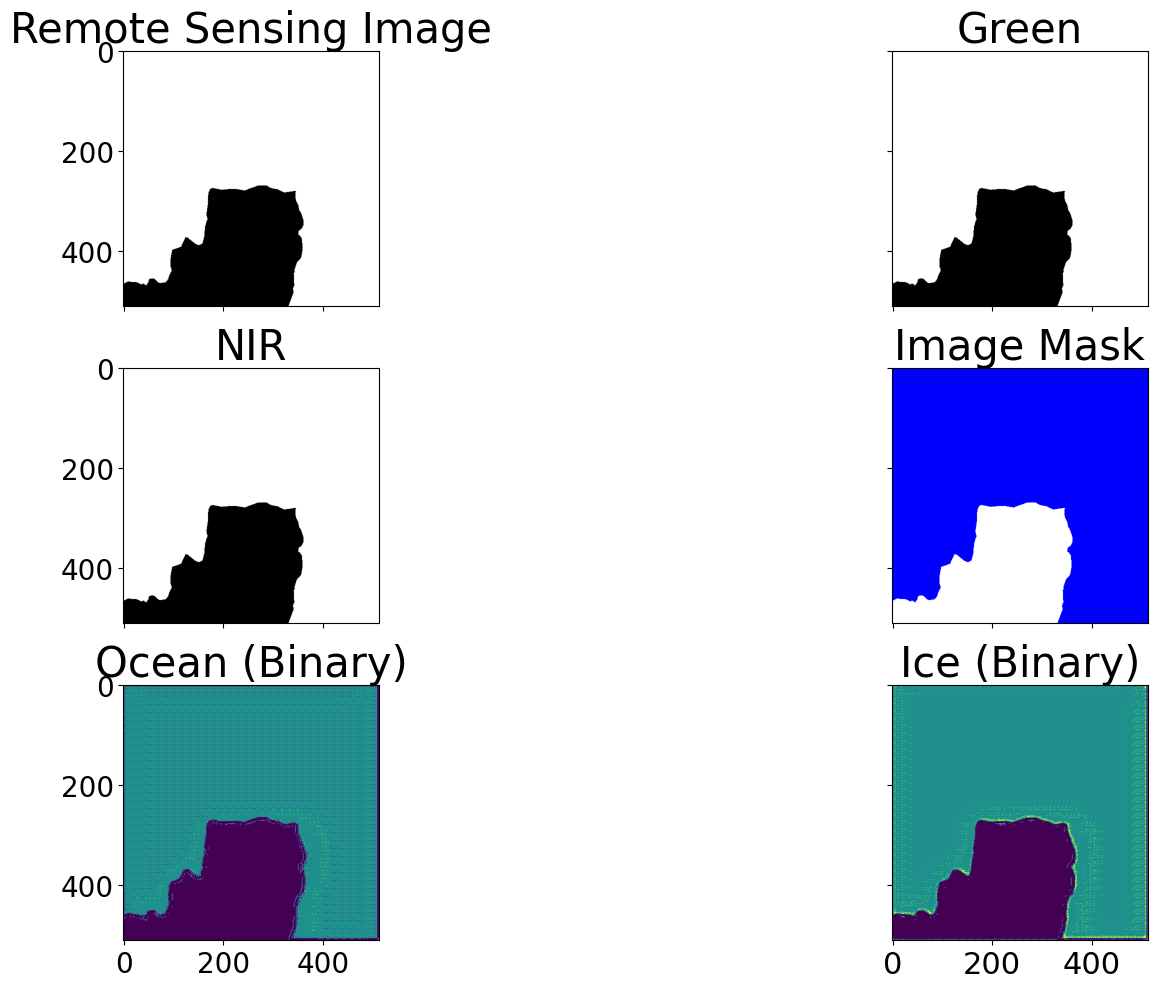

In [38]:
# Let's see how a prediction on the training data looks like
plot_sample_all(x_train, y_train, preds_train, preds_train_t, ix=9, filename='test.png')

Plot our test data as well

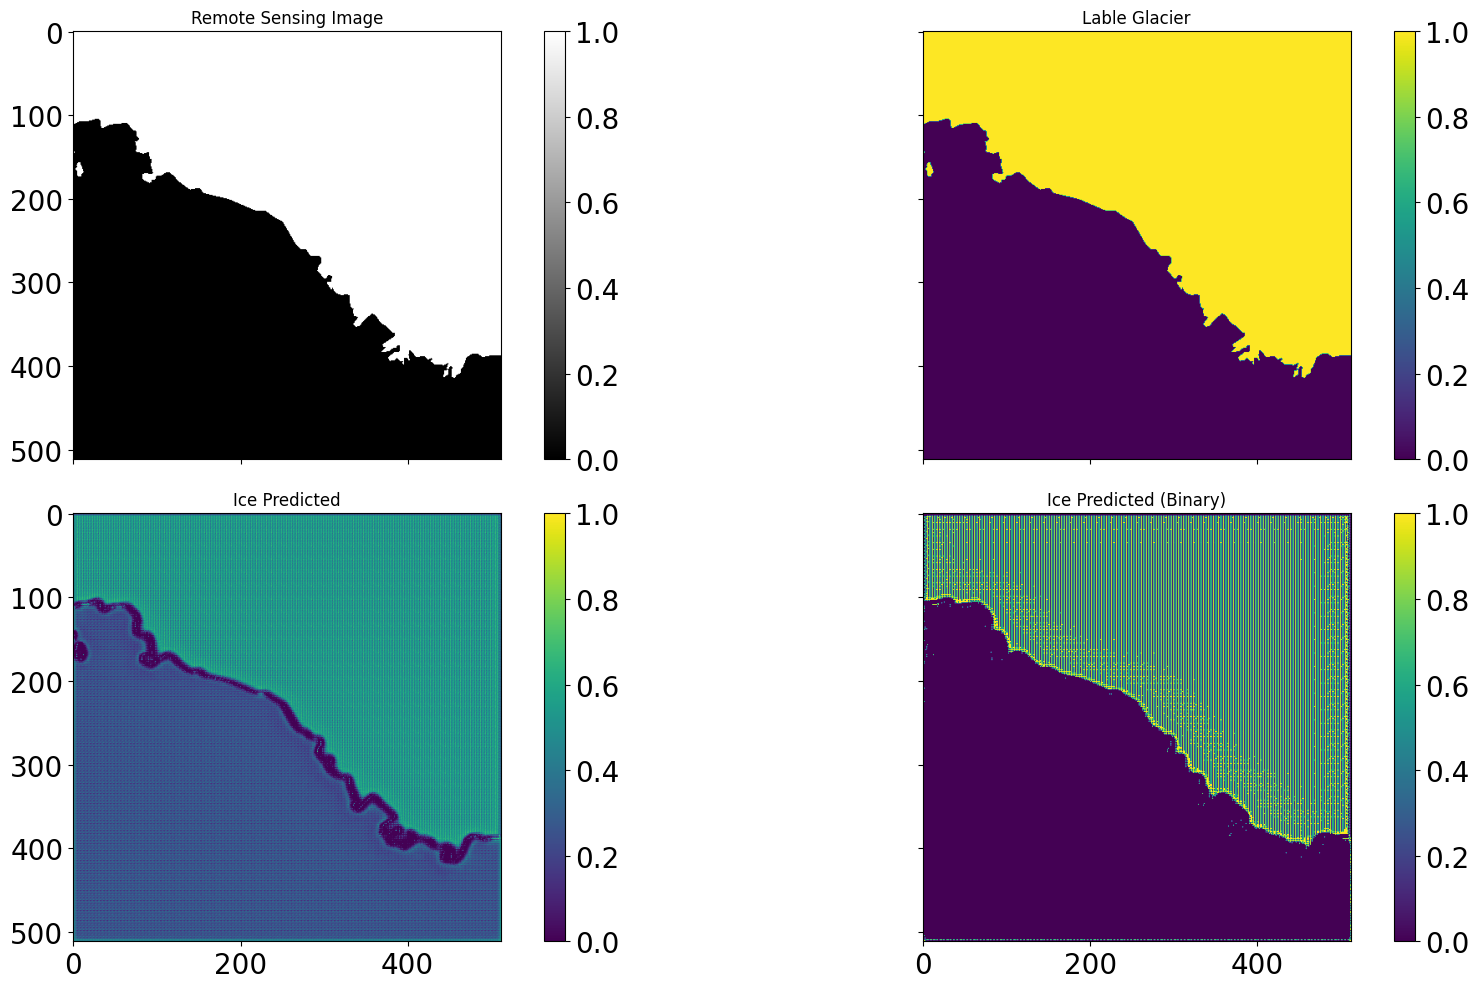

In [39]:
# Check if test data looks all right
plot_sample(x_test, y_test, preds_test, preds_test_t, ix=1)

#### Accuracy Metrics

In [40]:
x_total = np.concatenate((x_train, x_val, x_test), axis=0)
y_total = np.concatenate((y_train, y_val, y_test), axis=0)
pred_total = np.concatenate((preds_train_t, preds_val_t, preds_test_t), axis=0)

In [41]:
print_roc_metrics(y_val, preds_val_t)

Confusion matrix:
[[1401750  433258]
 [1364339  470669]]
F1 score: 0.3437
Recall score: 0.2565
Precision score: 0.5207
